# Построение модели регрессии, используя алгоритм градиентного бустинга, для задачи прогнозирования концентрации тяжелых металлов.

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [ ]:
SEED = 1 # для воспроизводимости результатов

## Подгрузка данных


In [ ]:
uri = open(".mongodb_token").read()

client = pymongo.MongoClient(uri)
db = client['heavymetals']
collection = db['heavymetals']

In [ ]:
df = pd.DataFrame(list(db.Fe_cor_indexes.find()))
df = df.dropna()

## Первичный анализ данных

In [ ]:
df.describe()

In [ ]:
df

,LC_Type4,SWIRVZA,VNIRVZA,SAA,SZA,TIME,LST_Day_1km,Night_view_time,Day_view_time,B5,...,SZEN,VZEN,B11,B6,sur_refl_b07,BRDF_Albedo_Parameters_Band6_geo,BRDF_Albedo_Parameters_Band6_iso,BRDF_Albedo_Parameters_Band7_geo,BRDF_Albedo_Parameters_Band7_iso,Fe
0,6.0,73.0,73.0,108.0,77.5,699.0,14864.5,221.0,110.0,14950.419341,...,4656.777778,3699.500000,22827.816975,13805.278284,1396.500000,54.5,294.500000,44.0,184.5,414.0679
1,6.0,73.0,73.0,108.0,77.5,700.0,15009.0,221.0,110.0,16227.613449,...,4638.583333,3693.500000,23251.804882,14170.123809,1687.500000,41.5,334.000000,31.0,208.5,679.3359
2,6.0,72.0,72.0,109.0,78.0,701.0,14832.0,221.0,110.0,16225.441665,...,4691.875000,3656.500000,22635.824845,14423.536211,1354.500000,57.0,293.166667,39.0,170.5,191.9459
3,2.0,73.0,73.0,109.0,79.0,701.0,14846.0,221.0,110.0,15969.163140,...,4656.250000,3648.541667,22468.118812,12886.915464,1032.000000,44.0,262.000000,33.0,142.0,256.0853
4,4.0,72.0,72.0,109.0,79.0,702.0,14944.5,221.0,111.0,15577.268577,...,4595.142857,3599.250000,22547.717038,14246.689616,1336.102642,69.0,317.500000,46.0,184.0,720.8943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,1.0,55.0,55.0,115.0,119.0,573.0,13639.5,210.0,120.0,13201.465095,...,6093.250000,3725.666667,17121.741984,8567.513688,495.000000,12.5,130.500000,6.0,57.0,4380.0000
4584,1.0,55.0,55.0,116.0,119.0,574.0,13661.5,209.0,121.0,15632.825340,...,6104.000000,3539.285714,17349.935914,9699.876964,691.000000,26.0,211.500000,11.0,93.0,6190.0000
4585,1.0,52.5,53.0,116.0,118.5,577.0,13615.0,209.0,121.0,14191.578955,...,6220.250000,3822.166667,17169.377438,9159.969833,427.500000,14.5,123.000000,8.0,51.0,5870.0000
4586,1.0,52.0,52.0,117.0,120.0,579.0,13609.5,210.0,121.0,13294.281481,...,6158.250000,3236.000000,17305.457150,8760.299543,430.000000,17.0,139.500000,8.0,60.0,6260.0000


In [ ]:
sum(df.isna().sum()>0) # значение 0, означает, что пропусков нет.

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4588 entries, 0 to 4587
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   LC_Type4                          4588 non-null   float64
 1   SWIRVZA                           4588 non-null   float64
 2   VNIRVZA                           4588 non-null   float64
 3   SAA                               4588 non-null   float64
 4   SZA                               4588 non-null   float64
 5   TIME                              4588 non-null   float64
 6   LST_Day_1km                       4588 non-null   float64
 7   Night_view_time                   4588 non-null   float64
 8   Day_view_time                     4588 non-null   float64
 9   B5                                4588 non-null   float64
 10  B6_VCID_1                         4588 non-null   float64
 11  B7                                4588 non-null   float64
 12  B8    

In [ ]:
df.skew()

SWIRVZA                             0.149360
VNIRVZA                             0.150495
SAA                                -0.279724
SZA                                -0.027169
TIME                                0.474878
LST_Day_1km                        -0.690076
Night_view_time                    -1.177084
Day_view_time                       0.974515
B5                                 -0.151168
B6_VCID_1                          -0.294196
B7                                  0.662493
B8                                 -0.302002
Range                               0.471309
SolarZenith                         0.822990
BT_CH3                             -0.423984
SZEN                                0.149712
VZEN                                0.216448
B11                                 0.267763
B6                                  0.189304
sur_refl_b07                       -0.208823
BRDF_Albedo_Parameters_Band6_geo   -1.772940
BRDF_Albedo_Parameters_Band6_iso    0.319533
BRDF_Albed

In [ ]:
df.corr()

In [ ]:
!pip install dataprep
!python -m pip install "dask[dataframe]" --upgrade  # or python -m pip install
from dataprep.eda import plot, plot_correlation, create_report, plot_missing

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
df = df.drop(columns=['num_observations_500m','num_observations_1km','LC_Type4','SolarAzimuth'])

In [ ]:
from scipy.stats import norm

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Преобразованное')

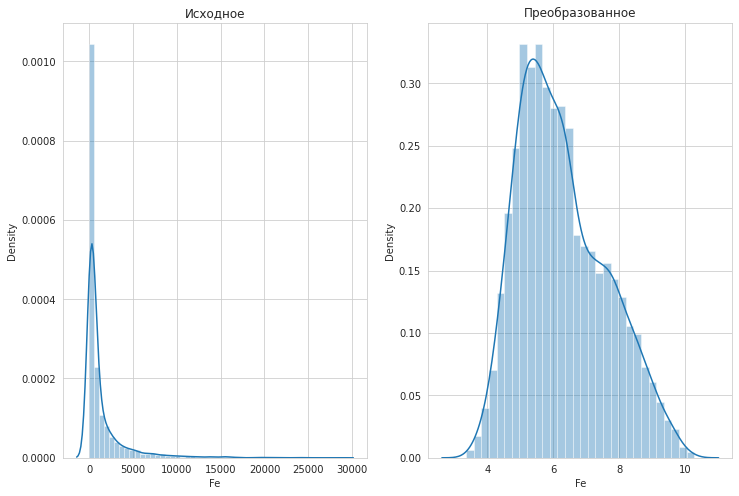

In [ ]:
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(12, 8)
sns.distplot(df['Fe'], ax=ax[0]).set_title('Исходное')
sns.distplot(np.log(df[('Fe')]+1), ax=ax[1]).set_title('Преобразованное')

In [ ]:
df['Night_view_time'] = np.log(df[('Night_view_time')]+1)
df['Day_view_time'] = np.log(df[('Day_view_time')]+1)
df['sur_refl_b07'] = np.log(df[('sur_refl_b07')]+1)
df['BRDF_Albedo_Parameters_Band6_geo'] = np.log(df[('BRDF_Albedo_Parameters_Band6_geo')]+1)
df['BRDF_Albedo_Parameters_Band7_iso'] = np.log(df[('BRDF_Albedo_Parameters_Band7_iso')]+1)
df['Fe'] = np.log(df[('Fe')]+1)

In [ ]:
create_report(df)

## LightGBM + Optuna

In [ ]:
!pip install optuna

In [ ]:
df

,SWIRVZA,VNIRVZA,SAA,SZA,TIME,LST_Day_1km,Night_view_time,Day_view_time,B5,B6_VCID_1,...,SZEN,VZEN,B11,B6,sur_refl_b07,BRDF_Albedo_Parameters_Band6_geo,BRDF_Albedo_Parameters_Band6_iso,BRDF_Albedo_Parameters_Band7_geo,BRDF_Albedo_Parameters_Band7_iso,Fe
0,73.0,73.0,108.0,77.5,699.0,14864.5,5.402677,4.709530,14950.419341,288.711898,...,4656.777778,3699.500000,22827.816975,13805.278284,7.242440,4.016383,294.500000,44.0,5.223055,6.028442
1,73.0,73.0,108.0,77.5,700.0,15009.0,5.402677,4.709530,16227.613449,290.169586,...,4638.583333,3693.500000,23251.804882,14170.123809,7.431596,3.749504,334.000000,31.0,5.344724,6.522587
2,72.0,72.0,109.0,78.0,701.0,14832.0,5.402677,4.709530,16225.441665,289.588141,...,4691.875000,3656.500000,22635.824845,14423.536211,7.211926,4.060443,293.166667,39.0,5.144583,5.262410
3,73.0,73.0,109.0,79.0,701.0,14846.0,5.402677,4.709530,15969.163140,289.077014,...,4656.250000,3648.541667,22468.118812,12886.915464,6.940222,3.806662,262.000000,33.0,4.962845,5.549408
4,72.0,72.0,109.0,79.0,702.0,14944.5,5.402677,4.718499,15577.268577,288.805483,...,4595.142857,3599.250000,22547.717038,14246.689616,7.198260,4.248495,317.500000,46.0,5.220356,6.581879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,55.0,55.0,115.0,119.0,573.0,13639.5,5.351858,4.795791,13201.465095,289.955891,...,6093.250000,3725.666667,17121.741984,8567.513688,6.206576,2.602690,130.500000,6.0,4.060443,8.385032
4584,55.0,55.0,116.0,119.0,574.0,13661.5,5.347108,4.804021,15632.825340,292.075813,...,6104.000000,3539.285714,17349.935914,9699.876964,6.539586,3.295837,211.500000,11.0,4.543295,8.730852
4585,52.5,53.0,116.0,118.5,577.0,13615.0,5.347108,4.804021,14191.578955,289.694498,...,6220.250000,3822.166667,17169.377438,9159.969833,6.060291,2.740840,123.000000,8.0,3.951244,8.677780
4586,52.0,52.0,117.0,120.0,579.0,13609.5,5.351858,4.804021,13294.281481,289.686131,...,6158.250000,3236.000000,17305.457150,8760.299543,6.066108,2.890372,139.500000,8.0,4.110874,8.742095


In [ ]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
df.iloc[:,:-1] = scaler.fit_transform(df.iloc[:,:-1])

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=SEED)
    param = {
        'metric': 'rmse', 
        'random_state': SEED,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100,120,150]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(test_x)
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-05-23 21:52:13,139] A new study created in memory with name: no-name-d8b3fad0-9a36-482c-943e-0f237ba19845
[I 2022-05-23 21:52:19,408] Trial 0 finished with value: 1.0939997903224068 and parameters: {'reg_alpha': 0.06012429008912045, 'reg_lambda': 0.0019728788140133645, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 736, 'min_child_samples': 64, 'min_data_per_groups': 47}. Best is trial 0 with value: 1.0939997903224068.
[I 2022-05-23 21:52:21,248] Trial 1 finished with value: 1.118313575996051 and parameters: {'reg_alpha': 0.03609090272307545, 'reg_lambda': 0.41354492434381607, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 120, 'num_leaves': 647, 'min_child_samples': 181, 'min_data_per_groups': 92}. Best is trial 0 with value: 1.0939997903224068.
[I 2022-05-23 21:52:24,678] Trial 2 finished with value: 1.1267116295029795 and parameters: {'reg_alpha': 1.7245562030232455, 'reg_lambda': 0.0011530204

Number of finished trials: 50
Best trial: {'reg_alpha': 0.6718262522834638, 'reg_lambda': 3.111944116226967, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 120, 'num_leaves': 81, 'min_child_samples': 21, 'min_data_per_groups': 95}


In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_min_data_per_groups,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,1.094000,2022-05-23 21:52:13.149810,2022-05-23 21:52:19.407555,0 days 00:00:06.257745,0.4,0.020,10,64,47,736,0.060124,0.001973,0.6,COMPLETE
1,1,1.118314,2022-05-23 21:52:19.410852,2022-05-23 21:52:21.247741,0 days 00:00:01.836889,0.5,0.014,120,181,92,647,0.036091,0.413545,0.8,COMPLETE
2,2,1.126712,2022-05-23 21:52:21.250459,2022-05-23 21:52:24.677736,0 days 00:00:03.427277,0.7,0.006,20,258,66,752,1.724556,0.001153,0.5,COMPLETE
3,3,1.079466,2022-05-23 21:52:24.681147,2022-05-23 21:52:29.069006,0 days 00:00:04.387859,0.5,0.008,100,39,12,888,0.012263,2.783657,0.8,COMPLETE
4,4,1.069237,2022-05-23 21:52:29.072965,2022-05-23 21:52:34.405954,0 days 00:00:05.332989,0.9,0.008,20,23,98,504,0.113568,7.028627,0.5,COMPLETE
5,5,1.133024,2022-05-23 21:52:34.409460,2022-05-23 21:52:37.962196,0 days 00:00:03.552736,0.4,0.008,120,292,1,44,0.063104,0.053829,0.6,COMPLETE
6,6,1.121271,2022-05-23 21:52:37.965686,2022-05-23 21:52:39.601637,0 days 00:00:01.635951,0.3,0.010,150,164,42,633,0.008995,0.559546,1.0,COMPLETE
7,7,1.123371,2022-05-23 21:52:39.606901,2022-05-23 21:52:40.367876,0 days 00:00:00.760975,0.9,0.010,10,180,25,690,0.002015,0.137903,0.5,COMPLETE
8,8,1.096853,2022-05-23 21:52:40.371535,2022-05-23 21:52:43.560581,0 days 00:00:03.189046,0.9,0.006,20,76,92,964,0.004357,0.436453,0.4,COMPLETE
9,9,1.116773,2022-05-23 21:52:43.563644,2022-05-23 21:52:45.033611,0 days 00:00:01.469967,0.5,0.014,120,182,16,396,0.150481,0.083532,0.4,COMPLETE


### Визуализация для анализа оптимизации гиперпараметров

plot_optimization_histor: показывает результаты всех испытаний, а также лучший результат на данный момент в каждой точке.

In [ ]:
optuna.visualization.plot_optimization_history(study)

plot_parallel_coordinate: интерактивно визуализирует гиперпараметры и оценки

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

**plot_contour:** отображает взаимодействие параметров на интерактивной диаграмме.

In [ ]:
optuna.visualization.plot_contour(study, params=['num_leaves',
                            'max_depth',
                            'subsample',
                            'learning_rate',
                            'subsample'])

Гистограмма вклада параметров в модель

In [ ]:

optuna.visualization.plot_param_importances(study)

In [ ]:
params=study.best_params   
params['random_state'] = SEED
params['n_estimators'] = 20000 
params['metric'] = 'rmse'
params['cat_smooth'] = params.pop('min_data_per_groups')

In [ ]:
params

{'cat_smooth': 95,
 'colsample_bytree': 0.7,
 'learning_rate': 0.017,
 'max_depth': 120,
 'metric': 'rmse',
 'min_child_samples': 21,
 'n_estimators': 20000,
 'num_leaves': 81,
 'random_state': 1,
 'reg_alpha': 0.6718262522834638,
 'reg_lambda': 3.111944116226967,
 'subsample': 0.8}

In [ ]:
del_lst = ['num_observations_1km','num_observations_500m','LC_Type4','Day_view_time']
columns = [el for el in columns if el not in del_lst]

In [ ]:
del_lst = ['num_observations_1km','num_observations_500m','LC_Type4','Day_view_time']
columns = [el for el in columns if el not in del_lst]

In [ ]:
columns = list(df.columns[:-1])

kf = KFold(n_splits=5,random_state=SEED,shuffle=True)
rmse=[]
n=0
for trn_idx, test_idx in kf.split(df[columns],df['Fe']):
    X_tr,X_val=df[columns].iloc[trn_idx],df[columns].iloc[test_idx]
    y_tr,y_val=df['Fe'].iloc[trn_idx],df['Fe'].iloc[test_idx]
    model = LGBMRegressor(**params)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    print(n+1,rmse[n])
    n+=1

print(f'mean: {np.mean(rmse)}')

1 1.0680363258755727
2 1.044270001910772
3 1.0851961542206445
4 1.0677726050335548
5 1.0100217692940896
mean: 1.055059371266927


In [ ]:
np.mean(rmse)

1.0557817532890774

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_val, model.predict(X_val))

0.37586869384555943

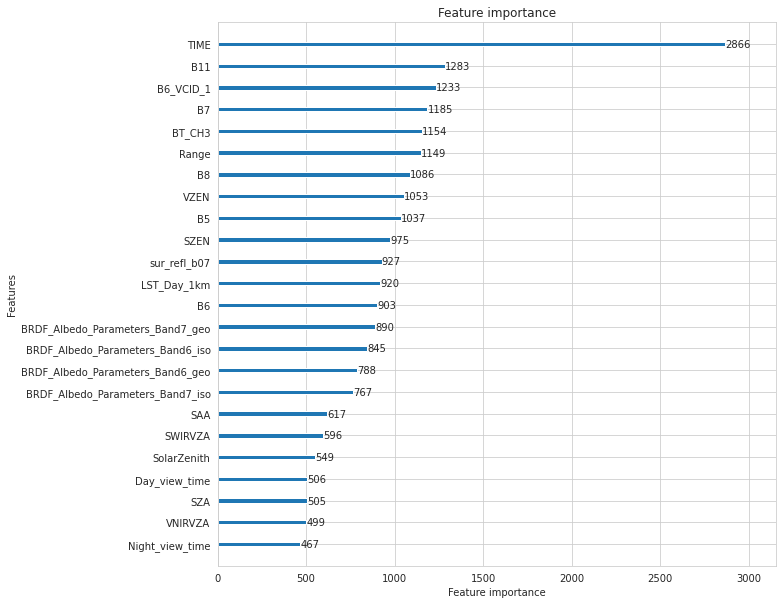

In [ ]:
from optuna.integration import lightgbm as lgb
lgb.plot_importance(model, max_num_features=30, figsize=(10,10))


## XGBRegressor

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
X,y= df.iloc[:,:-1], df.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=100)

In [ ]:
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

[11:16:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
y_pred = xgb_model.predict(X_test)

Test r2 score:  0.17118501413354614
Test RMSE: 1340.6991


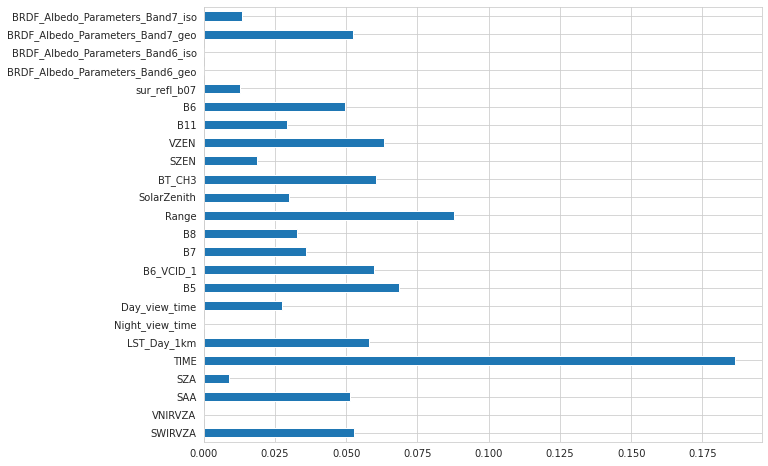

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('Test r2 score: ', r2)
print('Test RMSE: %.4f' % rmse)
plt.figure(figsize=(10, 8))
pd.Series(xgb_model.feature_importances_, index=X.columns).plot(kind='barh')
plt.show()

In [ ]:
X

,LC_Type4,SWIRVZA,VNIRVZA,SAA,SZA,TIME,LST_Day_1km,Night_view_time,Day_view_time,B5,...,num_observations_1km,num_observations_500m,obscov_500m,SZEN,VZEN,B6,sur_refl_b07,BRDF_Albedo_Parameters_Band6_iso,BRDF_Albedo_Parameters_Band7_geo,BRDF_Albedo_Parameters_Band7_iso
0,6.0,73.0,73.0,108.0,77.5,699.0,14864.5,221.0,110.0,0.168487,...,2.0,1.0,23.0,4656.777778,3699.500000,13805.278284,1401.166667,294.500000,44.0,184.5
1,6.0,73.0,73.0,108.0,77.5,700.0,15009.0,221.0,110.0,0.174864,...,2.0,1.0,24.0,4638.583333,3693.500000,14170.123809,1641.000000,334.000000,31.0,208.5
2,6.0,72.0,72.0,109.0,78.0,701.0,14832.0,221.0,110.0,0.180710,...,2.0,1.0,24.0,4691.875000,3656.500000,14423.536211,1340.000000,293.166667,39.0,170.5
3,2.0,73.0,73.0,109.0,79.0,701.0,14846.0,221.0,110.0,0.155214,...,2.0,1.0,24.0,4656.250000,3648.541667,12886.915464,1056.500000,262.000000,33.0,142.0
4,4.0,72.0,72.0,109.0,79.0,702.0,14944.5,221.0,111.0,0.182694,...,2.0,1.0,24.0,4595.142857,3599.250000,14246.689616,1312.343621,317.500000,46.0,184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,1.0,55.0,55.0,115.0,119.0,573.0,13639.5,210.0,120.0,0.110708,...,7.0,3.0,30.0,6093.250000,3725.666667,8567.513688,462.000000,130.500000,6.0,57.0
4580,1.0,55.0,55.0,116.0,119.0,574.0,13661.5,209.0,121.0,0.176695,...,7.0,3.0,29.0,6104.000000,3539.285714,9699.876964,663.000000,211.500000,11.0,93.0
4581,1.0,52.5,53.0,116.0,118.5,577.0,13615.0,209.0,121.0,0.113558,...,7.0,3.0,29.0,6220.250000,3822.166667,9159.969833,395.666667,123.000000,8.0,51.0
4582,1.0,52.0,52.0,117.0,120.0,579.0,13609.5,210.0,121.0,0.119470,...,8.0,3.0,30.0,6158.250000,3236.000000,8760.299543,383.833333,139.500000,8.0,60.0


### Выводы по регрессии
Исходя из полученных результов, можно сделать вывод, что модель регрессии не подходит для прогнозирования, потому что, она имеет большую ошибку и низкий коэффициент детерминации (R2). Для приемлемых моделей предполагается, что он должен быть более 0.50, в данном случае 0.19.